In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-white')

# Plot constants
WIDTH = 15
HEIGHT = 7

%matplotlib inline

## Load and clean up the data

The data comes from Caltrain: http://www.caltrain.com/developer.html

Unzip the files into a directory called `./data/`.

In [2]:
def csv_datetime(string):
    """Convert the time to a proper datetime.
    
    Caltrains uses 24 and 25 instead of next day 00 and 01, so we convert those properly."""
    DAY = 1
    # Caltrains uses 24 instead of 00, which breaks datetime
    if string[:2] == "24":
        string = "00" + string[2:]
        DAY += 1
    elif string[:2] == "25":
        string = "01" + string[2:]
        DAY += 1
        
    dt = datetime.strptime(string, "%H:%M:%S")
    dt = dt.replace(day=DAY)
    
    return dt

# Set Local, Limited, Bullet, Weekend Local, Weekend Bullet
def set_train_type(train_id):
    """Convert a train number to its service type."""
    # Buses use two digits
    if train_id < 99:
        return "bus"
    # Trains are identified by their leading digit
    leading = int(str(train_id)[0])
    if leading == 1:
        return "local"
    if leading == 2:
        return "limited"
    if leading == 3:
        return "bullet"
    if leading == 4:
        return "weekend local"
    if leading == 8:
        return "weekend bullet"
    return None

In [3]:
# Read in the schedule file
STOP_TIMES_FILE = "data/stop_times.txt"
df_stop_times = pd.read_csv(STOP_TIMES_FILE, converters={1: csv_datetime, 2: csv_datetime})

# Drop useless columns
USELESS = ['drop_off_type', 'pickup_type', 'departure_time']
df_stop_times.drop(USELESS, axis=1, inplace=True)

# Read in the trips table with information about the train numbers
TRIPS_FILE = "data/trips.txt"
df_trips = pd.read_csv(TRIPS_FILE)

# Drop useless columns
USELESS = ['bikes_allowed', 'wheelchair_accessible', 'block_id', 'shape_id', 'trip_headsign']
df_trips.drop(USELESS, axis=1, inplace=True)

# Read in the trips table with information about the train numbers
TRIPS_FILE = "data/stops.txt"
df_stops = pd.read_csv(TRIPS_FILE)

# Drop useless columns
USELESS = ['stop_desc', 'stop_lat', 'stop_lon', 'zone_id', 'stop_url', 'location_type', 'wheelchair_boarding', 'stop_code', 'parent_station', 'platform_code']
df_stops.drop(USELESS, axis=1, inplace=True)

# Join into a single table
df_temp = df_stop_times.merge(df_stops, on="stop_id")
df = df_temp.merge(df_trips, on="trip_id")

# Drop unused columsn
USELESS = ["stop_id", "trip_id", "route_id"]
df.drop(USELESS, axis=1, inplace=True)

# Set the direction in a human-readable fashion
direction_map = {0: "north", 1: "south"}
df["direction"] = df["direction_id"].replace(direction_map)

# Set the day of the week
day_map = {"CT-17APR-Caltrain-Saturday-01": "saturday", "CT-17APR-Caltrain-Sunday-01": "sunday", "CT-17APR-Combo-Weekday-01": "weekday"}
df["day"] = df["service_id"].replace(day_map)

# Drop unused columns
UNUSED = ["direction_id", "service_id"]
df.drop(UNUSED, axis=1, inplace=True)

df["train_type"] = df["trip_short_name"].apply(set_train_type)

# Remove busses
df = df[df["train_type"] != "bus"]

# Rename columns
new_names = {"arrival_time": "time", "trip_short_name": "train_id",}
df.rename(columns=new_names, inplace=True)

## Map station to distance

This uses the track mile markers, as reported by Wikipedia: https://en.wikipedia.org/wiki/List_of_Caltrain_stations

As they note: "Station mileposts are based on track distance from the former 3rd and Townsend Southern Pacific Depot 0.2 miles northeast of the current San Francisco station. Actual station distances south of Lawrence station no longer match the given mileposts (e.g. current track distance from San Francisco to the San Jose station is 46.8 miles)."

This is acceptable error, as I tried to measure using Google Maps and found that I was off by far more than 0.1 miles after only measuring half way to San Jose.

In [4]:
station_mile_markers = {
    '22nd St Caltrain': 1.9,
    'Atherton Caltrain': 27.8,
    'Bayshore Caltrain': 5.2,
    'Belmont Caltrain': 21.9,
    'Blossom Hill Caltrain': 55.7,
    'Broadway Caltrain': 15.2,
    'Burlingame Caltrain': 16.3,
    'California Ave Caltrain': 31.8,
    'Capitol Caltrain': 52.4,
    'College Park Caltrain': 45.7,
    'Gilroy Caltrain': 77.4,
    'Hayward Park Caltrain': 19.1,
    'Hillsdale Caltrain': 20.3,
    'Lawrence Caltrain': 40.8,
    'Menlo Park Caltrain': 28.9,
    'Millbrae Caltrain': 13.7,
    'Morgan Hill Caltrain': 67.5,
    'Mt View Caltrain': 36.1,
    'Palo Alto Caltrain': 30.1,
    'Redwood City Caltrain': 25.4,
    'San Antonio Caltrain': 34.1,
    'San Bruno Caltrain': 11.6,
    'San Carlos Caltrain': 23.2,
    'San Francisco Caltrain': 0.2,
    'San Jose Diridon Caltrain': 46.9,
    'San Martin Caltrain': 71.2,
    'San Mateo Caltrain': 17.9,
    'Santa Clara Caltrain': 44.3,
    'So. San Francisco Caltrain Station': 9.3,
    'Stanford': 30.8,
    'Sunnyvale Caltrain': 38.8,
    'Tamien Caltrain': 49.1,
}

# We would like San Francisco (the North most station) to be on the top, so we reverse the Y coordinates
end_distance = max(station_mile_markers.values())
stop_name_to_y = {key: end_distance - value for key, value in station_mile_markers.items()}

In [5]:
def get_y(series):
    day = series[5]
    station = series[2]
    return stop_name_to_y[station]

df["y"] = df.apply(get_y, axis=1)

## Plot the schedules

In [6]:
def plot_marey_schedule(
    ax, 
    day, # saturday, sunday, weekday
    direction, # north, south, both
    colors,
    hour_range=(datetime(1900, 1, 1, 4, 45), datetime(1900, 1, 2, 2)),
    stations=("San Francisco Caltrain", "San Jose Diridon Caltrain")
):
    # Get a dataframe of desired trains
    if day not in ["saturday", "sunday", "weekday"]:
        raise ValueError("Invalid day value.")

    selection = (df["day"] == day)
    df_plot = df[selection][["time", "train_id", "y", "train_type", "direction"]]

    stop_name_map = stop_name_to_y

    # Get the max and minimum Y values
    y_limit = []
    for station in stations:
        y_limit.append(stop_name_map[station])
    
    max_y = max(y_limit)
    min_y = min(y_limit)

    # Plot lines
    for key, group in df_plot.groupby(['train_id']):
        group = group.sort_values(by="time")
    
        # Set color
        train_type = group["train_type"].iloc[0]
        if "local" in train_type:
            color = colors[0]
        elif "limited" in train_type:
            color = colors[1]
        else:
            color = colors[2]
            
        # Set alpha
        alpha = 1
        zorder = 3
        if direction is not "both":
            if not direction in group["direction"].iloc[0]:
                alpha = 0.2
                zorder -= 1
        
        ax.plot(group['time'], group['y'], color=color, label="Train {}".format(key), zorder=zorder, alpha=alpha)
        if alpha == 1:
            ax.scatter(list(group['time']), group['y'], s=10, facecolors='w', edgecolors=color, linewidth=1, zorder=4)
    
    # Set the Y labels and lines
    station_map = {
        'San Francisco Caltrain': "San Francisco",
        'Millbrae Caltrain': "Millbrae",
        'San Mateo Caltrain': "San Mateo",
        'Hillsdale Caltrain': "Hillsdale",
        'Redwood City Caltrain': "Redwood City",
        'Palo Alto Caltrain': "Palo Alto",
        'Mt View Caltrain': "Mountain View",
        'Sunnyvale Caltrain': "Sunnyvale",
        'San Jose Diridon Caltrain': "Diridon",
        'Gilroy Caltrain': "Gilroy",
    }
    ys = []
    y_labels = []
    for key, value in station_map.items():
        y = stop_name_map.get(key, None)
        if y is not None:
            ys.append(y)
            y_labels.append(value)

    plt.yticks(ys, y_labels, size=12)

    for y in ys:
        ax.axhline(y, color='.6', linestyle='-', linewidth=0.4, zorder=1)

    # Set up the X labels
    xs = [datetime(1900, 1, 1, i) for i in range(4, 24)] + [datetime(1900, 1, 2, i) for i in range(0, 3)]
    x_labels = list(range(4, 25)) + list(range(1, 3))

    plt.xticks(xs, x_labels, size="x-large")

    for x in xs:
        ax.axvline(x, color='.6', linestyle='-', linewidth=0.4, zorder=1)
        
    # Shade every other hour
    for i in range(4, 24, 2):
        start = datetime(1900, 1, 1, i)
        end = datetime(1900, 1, 1, i+1)
        ax.axvspan(start, end, color="black", alpha=0.03, zorder=0)
        
    for i in range(0, 3, 2):
        start = datetime(1900, 1, 2, i)
        end = datetime(1900, 1, 2, i+1)
        ax.axvspan(start, end, color="black", alpha=0.03, zorder=0)

    # Adjust plot size
    ax.set_xlim(hour_range)
    ax.set_ylim([min_y-2, max_y+2])

    return ax

In [7]:
# Setup the colors
current_palette = sns.color_palette("Set1", 3)
red = current_palette[0]
blue = current_palette[1]
green = current_palette[2]
colors = (blue, green, red)

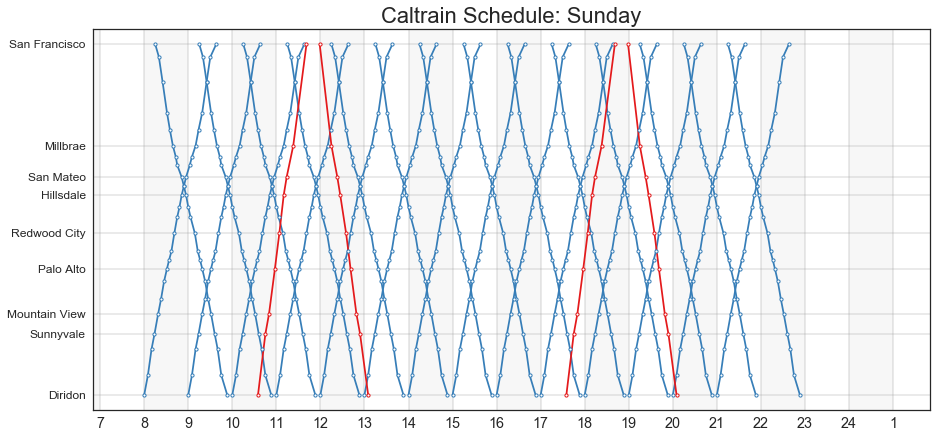

In [8]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = plot_marey_schedule(ax, "sunday", "both", colors, (datetime(1900, 1, 1, 6, 50), datetime(1900, 1, 2, 1, 50)))

plt.title("Caltrain Schedule: Sunday", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/caltrain_sunday.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)

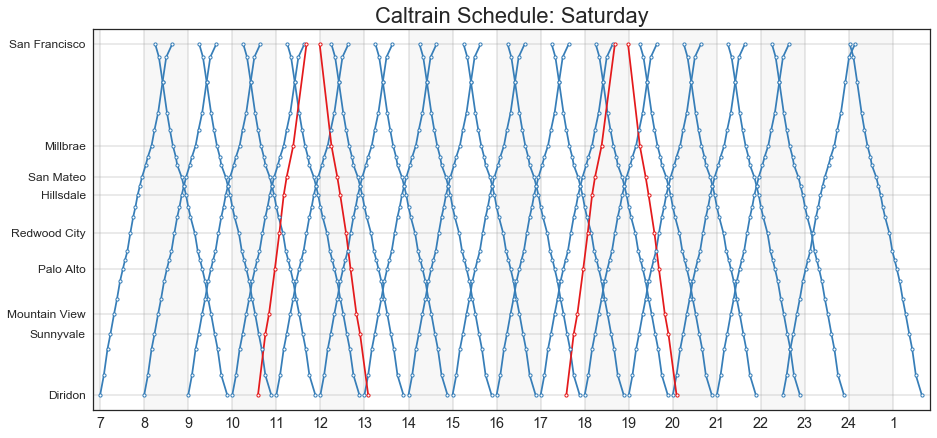

In [9]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = plot_marey_schedule(ax, "saturday", "both", colors, (datetime(1900, 1, 1, 6, 50), datetime(1900, 1, 2, 1, 50)))

plt.title("Caltrain Schedule: Saturday", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/caltrain_saturday.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)

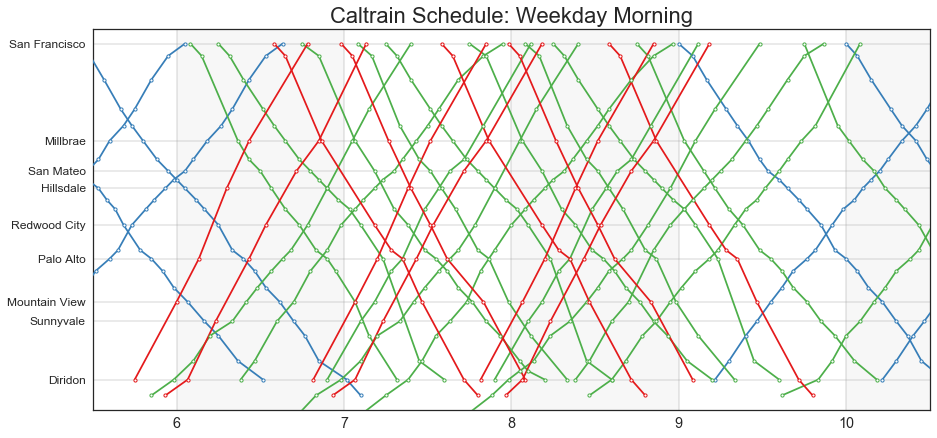

In [10]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = plot_marey_schedule(ax, "weekday", "both", colors, (datetime(1900, 1, 1, 5, 30), datetime(1900, 1, 1, 10, 30)), ('San Francisco Caltrain', 'Tamien Caltrain'))

plt.title("Caltrain Schedule: Weekday Morning", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/caltrain_weekday_morning.{ext}".format(ext=ext), bbox_inches="tight")

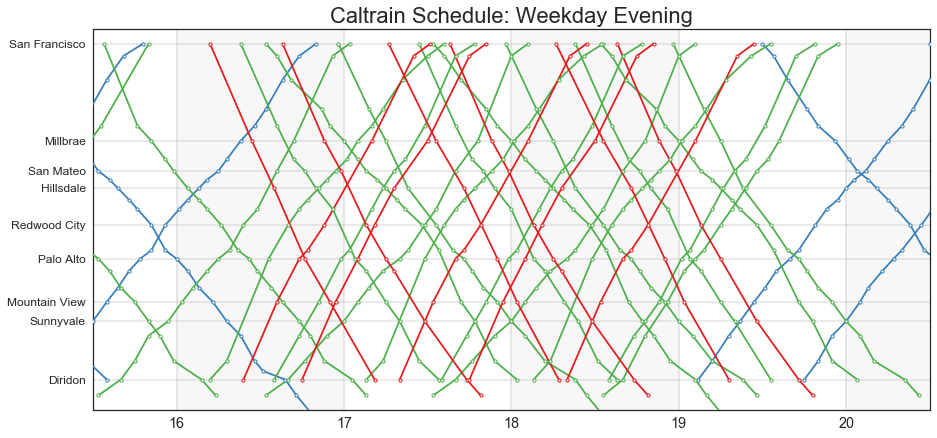

In [11]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = plot_marey_schedule(ax, "weekday", "both", colors, (datetime(1900, 1, 1, 15, 30), datetime(1900, 1, 1, 20, 30)), ('San Francisco Caltrain', 'Tamien Caltrain'))

plt.title("Caltrain Schedule: Weekday Evening", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/caltrain_weekday_evening.{ext}".format(ext=ext), bbox_inches="tight")

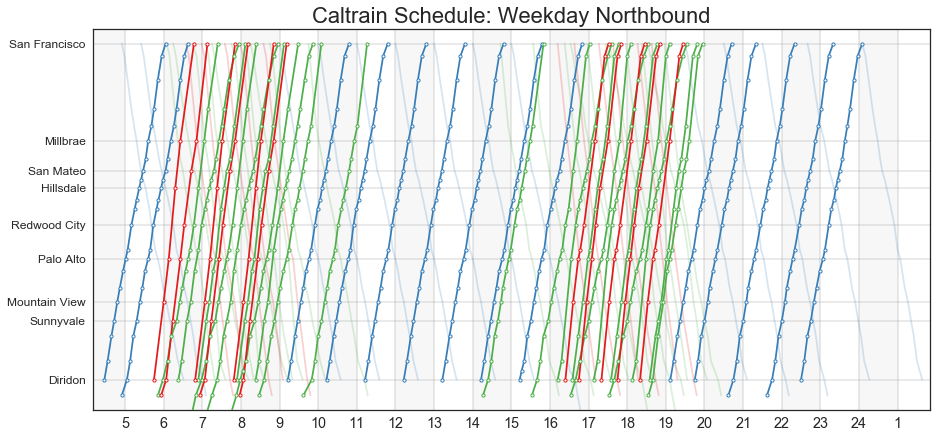

In [12]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = plot_marey_schedule(ax, "weekday", "north", colors, (datetime(1900, 1, 1, 4, 10), datetime(1900, 1, 2, 1, 50)), ('San Francisco Caltrain', 'Tamien Caltrain'))

plt.title("Caltrain Schedule: Weekday Northbound", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/caltrain_weekday_north.{ext}".format(ext=ext), bbox_inches="tight")

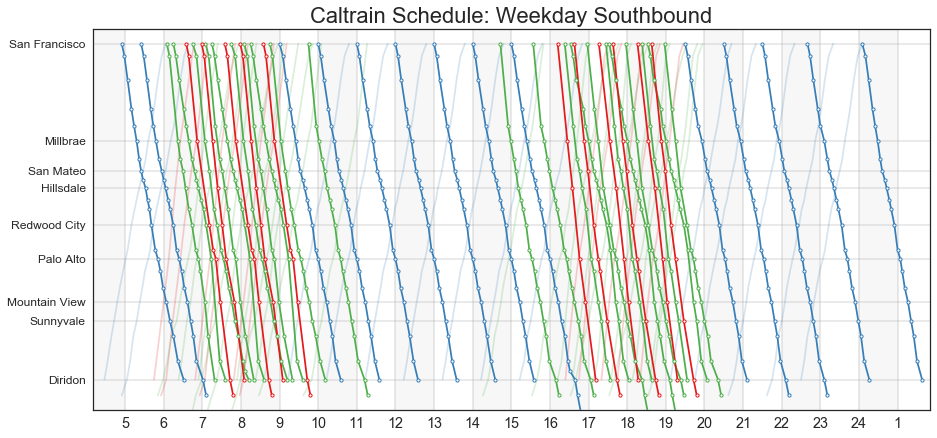

In [13]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = plot_marey_schedule(ax, "weekday", "south", colors, (datetime(1900, 1, 1, 4, 10), datetime(1900, 1, 2, 1, 50)), ('San Francisco Caltrain', 'Tamien Caltrain'))

plt.title("Caltrain Schedule: Weekday Southbound", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/caltrain_weekday_south.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)

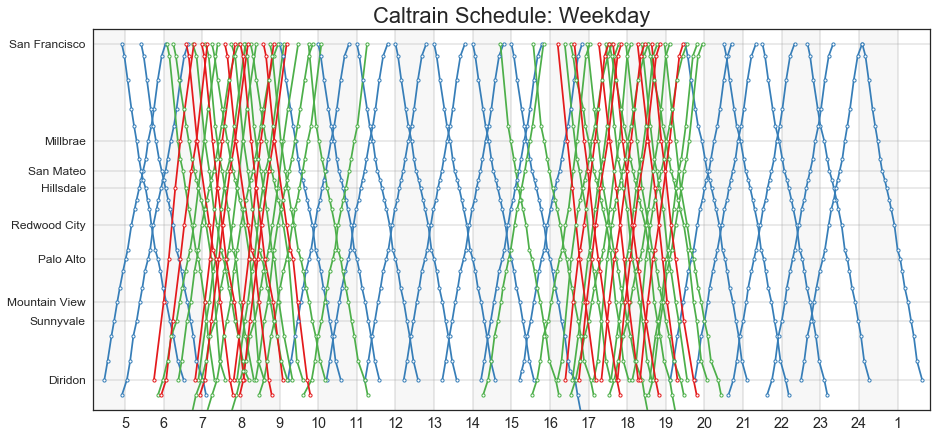

In [14]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = plot_marey_schedule(ax, "weekday", "both", colors, (datetime(1900, 1, 1, 4, 10), datetime(1900, 1, 2, 1, 50)), ('San Francisco Caltrain', 'Tamien Caltrain'))

plt.title("Caltrain Schedule: Weekday", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/caltrain_weekday.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)

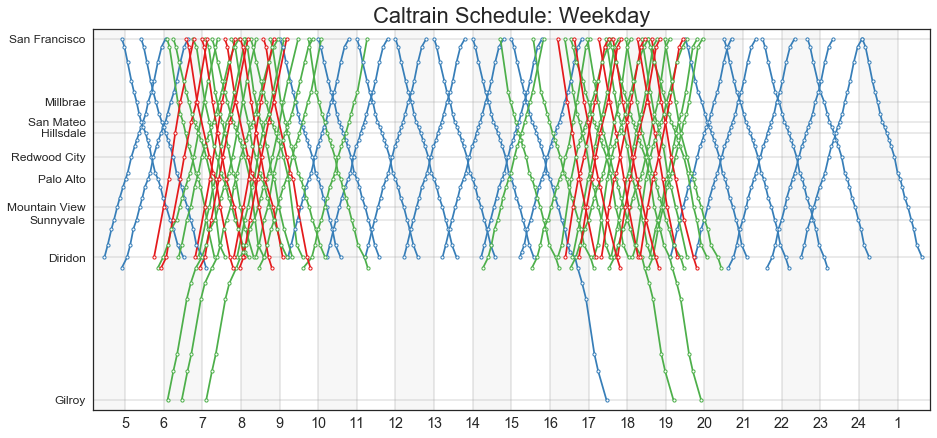

In [15]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = plot_marey_schedule(ax, "weekday", "both", colors, (datetime(1900, 1, 1, 4, 10), datetime(1900, 1, 2, 1, 50)), ('San Francisco Caltrain', 'Gilroy Caltrain'))

plt.title("Caltrain Schedule: Weekday", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/caltrain_weekday_gilroy.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)